In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error,mean_absolute_error
from ipywidgets import interact

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
port_path = "Prueba.xlsx"
market = pd.read_excel(port_path, index_col=0)

In [4]:
market.head()

,KIMBERA MF Equity,GAPB MF Equity,CEMEXCPO MF Equity,ASURB MF Equity,GFNORTEO MF Equity,KOFUBL MF Equity,AC* MF Equity,LABB MF Equity,FEMSAUBD MF Equity,OMAB MF Equity,...,MEGACPO MF Equity,GCC* MF Equity,BIMBOA MF Equity,GMEXICOB MF Equity,GCARSOA1 MF Equity,TLEVICPO MF Equity,ALFAA MF Equity,BSMXB MF Equity,PINFRA* MF Equity,MEXBOL INDEX
DATE,,,,,,,,,,,,,,,,,,,,,
2016-01-01,40.37,152.05,8.72,243.89,94.99,123.90,104.68,13.85,161.63,83.61,...,64.19,44.81,45.95,36.79,70.98,94.34,34.10,30.25,202.73,42977.50
2016-01-04,39.16,148.57,8.43,238.29,91.79,120.29,102.09,14.41,157.62,81.77,...,64.45,43.51,45.02,35.71,69.83,92.62,33.74,29.46,202.93,42113.70
2016-01-05,38.89,147.93,8.31,233.03,91.72,118.82,101.12,13.77,157.80,81.58,...,63.16,43.51,45.77,36.45,70.70,91.89,33.99,29.72,203.56,42041.68
2016-01-06,39.13,146.99,8.29,231.97,91.63,120.32,102.50,13.65,156.37,82.03,...,63.27,43.51,45.97,35.57,70.47,90.41,33.65,29.67,199.80,41691.19
2016-01-07,39.16,141.32,7.64,230.71,89.54,120.20,101.16,13.25,155.14,80.94,...,62.78,42.76,46.18,35.01,68.15,90.23,31.46,28.50,196.75,40661.57


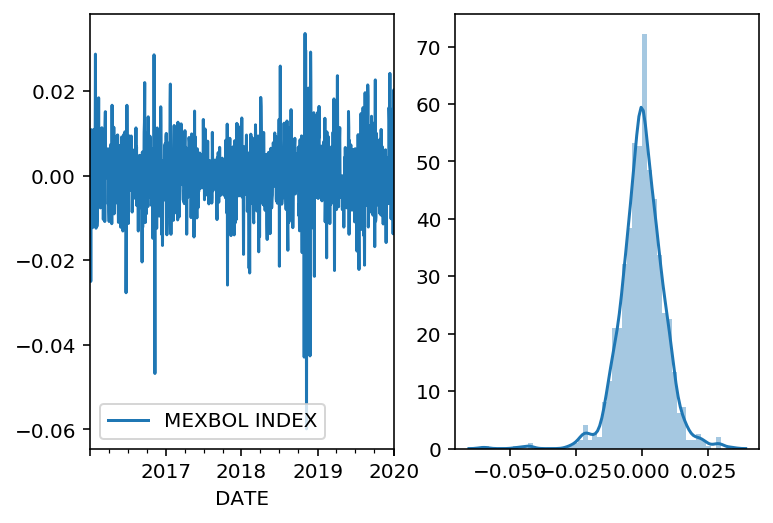

In [5]:
import seaborn as sns
R=market[['MEXBOL INDEX']]
R=np.log(R).diff().dropna()
fig,ax=plt.subplots(1,2)
R.plot(ax=ax[0])
sns.distplot(R,ax=ax[1])

In [6]:
test_year="2018-12-31"
R_train=R[:test_year]
R_test=R[test_year:]

# GARCH(1,1)

**Modelo de volatilidad dinamica**

$\sigma_t^2=(1-\lambda)r_{t-1}^2+\lambda\sigma_{t-1}^2$

In [7]:
class GARCHdin:
    """
    Clase para estimar sigmas para un GARCH(1, 1)
    """
    def __init__(self,lamda, sigma_init, R):
        self.lamda = lamda
        self.R = R
        self.sigma_hist = [sigma_init]
        self.initialize_sigmas()
        
    def get_sigma1(self, t):
        rt0 = 0 if t == 0 else self.R.iloc[t - 1, 0]
        sigma0 = self.sigma_hist[-1]
        sigma1 = (1-self.lamda) * rt0 ** 2 + self.lamda * sigma0
        self.sigma_hist.append(sigma1)
    
    def initialize_sigmas(self):
        N, M = self.R.shape
        for t in range(N - 1, -1, -1):
            self.get_sigma1(t)

In [8]:
def LGarch(lamda,sigma_init,R):
    s=GARCHdin(lamda,sigma_init,R)
    sigma_hist=np.array(s.sigma_hist[1:])
    r1_2=R.values.ravel()**2
    log_likelihood=(np.log(sigma_hist)+r1_2/sigma_hist).sum()/2
    return log_likelihood

**Minimizamos $\lambda$ para datos de train**

In [9]:
from numpy.random import random,seed
seed(314)
lamda=np.abs(random())
sigma_init=R_train.var(ddof=1).item()/252
LGarch(lamda,sigma_init,R_train)

/home/abraham/anaconda4/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: `item` has been deprecated and will be removed in a future version
  after removing the cwd from sys.path.


-2528.7725359862243

In [10]:
x0=lamda
L_part=lambda x0:LGarch(x0,sigma_init,R_train)
def cons(x):
    return 1-x

def cons2(x):
    return x
    
bounds=[(0,None)]    

fmin=minimize(L_part,x0,constraints=[{"type":"ineq","fun":cons},{"type":"ineq","fun":cons2}],bounds=bounds)

In [11]:
fmin

     fun: -2373114.1343591944
     jac: array([-0.28125])
 message: 'Optimization terminated successfully.'
    nfev: 17
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.91036391])

In [12]:
lamdag=fmin.x

In [13]:
fmin.x

array([0.91036391])

**Revisamos estimaciones para Train y Test**

In [14]:
#estimacion garch
sigma0=sigma_init
garch_predict_t=[]
for i in range(len(R_train)):
    sigma0=(1-lamdag) * R_train.iloc[i].item()**2 + lamdag * sigma0#og+ag*R.iloc[i].item()**2+bg*sigma0
    garch_predict_t.append(sigma0)

/home/abraham/anaconda4/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: `item` has been deprecated and will be removed in a future version
  """


In [15]:
#estimacion garch
sigma0=R_test.var(ddof=1).item()/252
garch_predict=[]
for i in range(len(R_test)):
    sigma0=(1-lamdag) * R_test.iloc[i].item()**2 + lamdag * sigma0#og+ag*R.iloc[i].item()**2+bg*sigma0
    garch_predict.append(sigma0)

/home/abraham/anaconda4/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: `item` has been deprecated and will be removed in a future version
  
/home/abraham/anaconda4/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: `item` has been deprecated and will be removed in a future version
  """


**Analizamos el ajuste del modelo GARCH  utilizando la exponencial de la media ponderada de la varianze ewm en una ventana de 3 mese tabto para el estimado como para el real**

**medimos el error usando MSE y MAE**

In [16]:
def ajusta(n):
    plt.style.use("fivethirtyeight")
    fig,ax=plt.subplots(1,2,figsize=(15,5))
    xaxis_t=R_train.index[1:]
    sigma_garch_t=np.sqrt(garch_predict_t)[1:]
    mse_train=mean_squared_error(R_train.ewm(n).std()[1:].values,pd.DataFrame(sigma_garch_t).ewm(n).mean())
    mae_train=mean_absolute_error(R_train.ewm(n).std()[1:].values,pd.DataFrame(sigma_garch_t).ewm(n).mean())
    ax[0].plot(xaxis_t,R_train.ewm(n).std()[1:],color="b",label="var real")
    ax[0].plot(xaxis_t,pd.DataFrame(sigma_garch_t).ewm(n).mean(),color="r",label=f"prediccion MSE:{np.round(mse_train,8)}\MAE:{np.round(mae_train,4)}")
    ax[0].legend()
    ax[0].set_title(f"GARCH(1,1) Train $\lambda=${lamdag}")
    xaxis=R_test.index[1:]
    sigma_garch=np.sqrt(garch_predict)[1:]
    mse_test=mean_squared_error(R_test.ewm(n).std()[1:].values,pd.DataFrame(sigma_garch).ewm(n).mean())
    mae_test=mean_absolute_error(R_test.ewm(n).std()[1:].values,pd.DataFrame(sigma_garch).ewm(n).mean())
    ax[1].plot(xaxis,R_test.ewm(n).std()[1:],color="b",label="var real")
    ax[1].plot(xaxis,pd.DataFrame(sigma_garch).ewm(n).mean(),color="r",label=f"prediccion MSE:{np.round(mse_test,8)}\MAE:{np.round(mae_test,4)}")
    ax[1].legend()
    ax[1].set_title(f"GARCH(1,1) Test $\lambda=${lamdag}") 

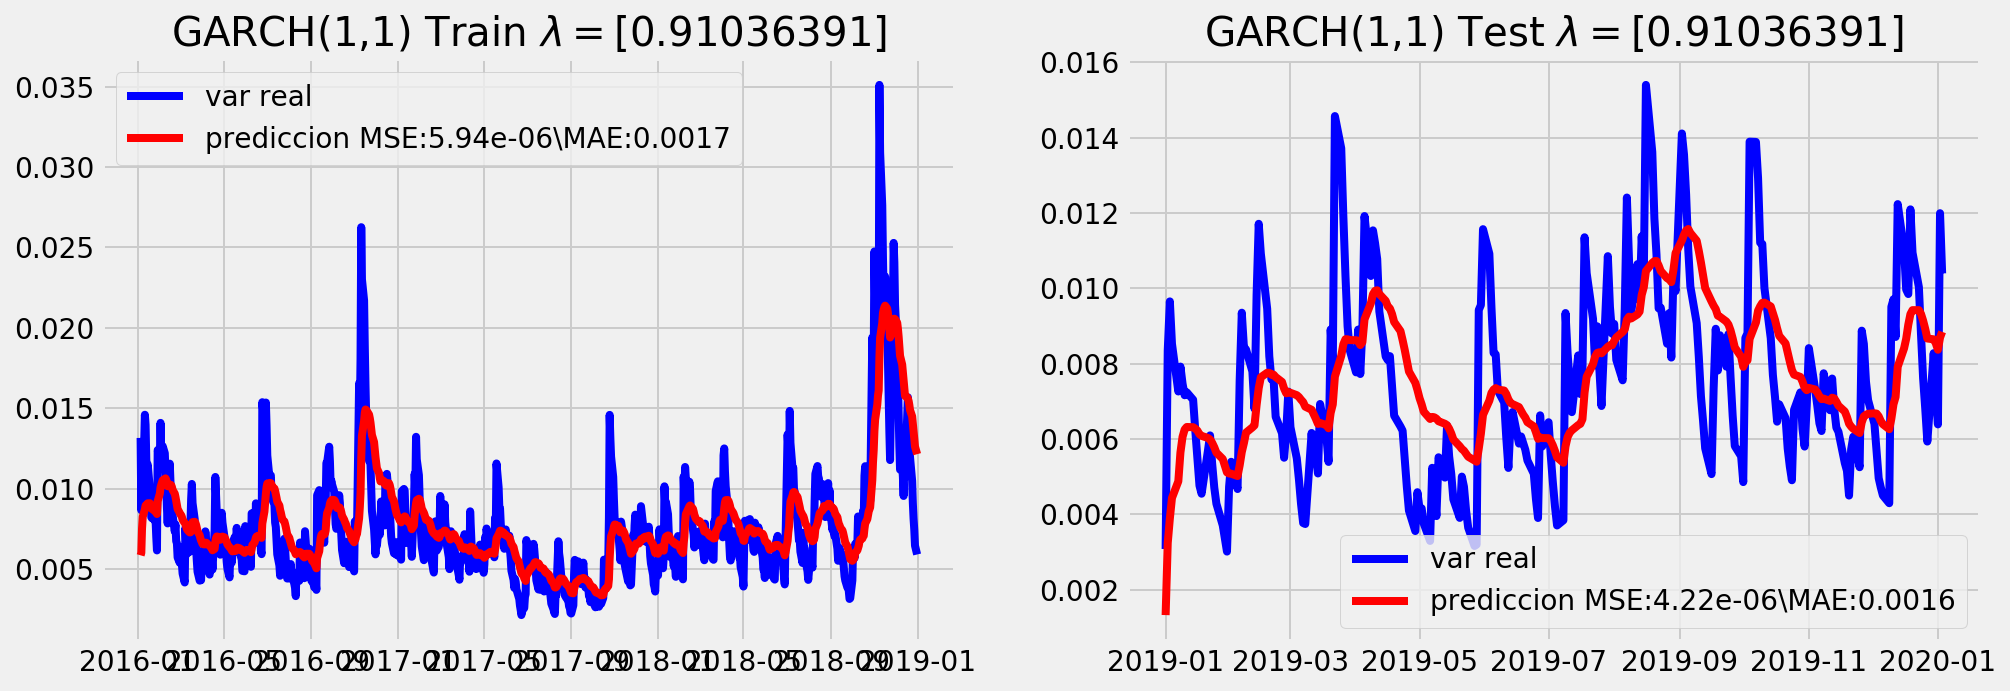

In [17]:
ajusta(3)

# Si cambiamos las ventanas?

In [18]:
interact(ajusta,n=(1,20)) 

interactive(children=(IntSlider(value=10, description='n', max=20, min=1), Output()), _dom_classes=('widget-in…

<function __main__.ajusta(n)>

**Como es de esperar mientras mas largas las ventanas el ajuste es mucho sobre todo basados en el mae**